## Fraction of halo-like stars in Gaia RVS sample as a function of FeH_template



## Import modules

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import print_function

import os, os.path 
#os.environ["OMP_NUM_THREADS"] = "1"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
import math
import numpy
import numpy as np
import scipy
from scipy import stats
import datetime, time


#agama
import agama, numpy
import configparser
from scipy.optimize import minimize
from useful_functions import *
agama.setUnits( mass=1., length=1, velocity=1)
_k = 4.74047

#import emcee, corner
#import multiprocessing as mp

#PyGaia
from pygaia.astrometry.coordinates import CoordinateTransformation, Transformations
from pygaia.astrometry.vectorastrometry import cartesianToSpherical, astrometryToPhaseSpace, phaseSpaceToAstrometry
from pygaia.errors.astrometric import properMotionErrorSkyAvg, properMotionMinError, properMotionMaxError
from pygaia.photometry.utils import vminiFromSpt, vabsFromSpt
from pygaia.photometry.transformations import gminvFromVmini

#read table
from astropy import table
from astropy.table import Table
import pandas
import copy 

#plot
import matplotlib
from matplotlib import pyplot
from matplotlib.ticker import MaxNLocator

pyplot.rcParams['ps.useafm'] = True
pyplot.rcParams['pdf.use14corefonts'] = True
pyplot.rcParams['text.usetex'] = True
#
#pyplot.rcParams["font.family"] = ["Computer Modern"]

In [2]:
_xGC_sun_kpc = -8.178  #you can set to (-_R0) if you want
_yGC_sun_kpc =  0.
_zGC_sun_kpc =  0.
_vxGC_sun    =  11.1
_vyGC_sun    =  247.30 #245.61  #232.24 #you can set to (_V0) if you want
_vzGC_sun    =  7.25

#LSR 233.37 

In [3]:
# set potential
potM17 = agama.Potential('/Users/kohei/my_libs_3/Agama/data/McMillan17.ini')

## Read data 

In [4]:
# read
inputfile_m1p5 = '../RVS_0absb_withplx_FeHm1p5_Teff-result.fits'
data_m1p5 =table.Table.read(inputfile_m1p5)

inputfile_m1p0 = '../RVS_0absb_withplx_FeHm1p0_Teff-result.fits'
data_m1p0 =table.Table.read(inputfile_m1p0)

inputfile_m0p5 = '../RVS_0absb_withplx_FeHm0p5_Teff-result.fits'
data_m0p5 =table.Table.read(inputfile_m0p5)

inputfile_m0p0 = '../RVS_0absb_withplx_FeHm0p0_Teff-result.fits'
data_m0p0 =table.Table.read(inputfile_m0p0)

In [5]:
data_m1p5.columns

<TableColumns names=('source_id','ra','dec','b','l','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','radial_velocity','radial_velocity_error','rv_template_fe_h','teff_val','bp_rp','phot_g_mean_mag')>

In [6]:
data_m1p5

source_id,ra,dec,b,l,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,radial_velocity,radial_velocity_error,rv_template_fe_h,teff_val,bp_rp,phot_g_mean_mag
,deg,deg,deg,deg,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,km / s,km / s,dex,K,mag,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32
2021659939697145728,295.2736692126975,25.330212432523595,1.2693896533258162,60.93275623833162,2.1587254165453444,0.021978824691060835,-13.992715222049894,0.03179828287693372,-12.799978783796927,0.035195900160036264,10.085115397627476,5.955380543867405,-1.5,5316.6665,1.0075178,13.362812
6680793183361589248,307.1768672145168,-39.93369279524846,-35.00973381829829,1.4852858891748753,2.4261515456258382,0.05161408628356239,-0.6991025279894931,0.07367573236906141,-5.530492089850285,0.048105199285201496,98.26251032031934,2.152257917103852,-1.5,6586.75,0.75707245,12.328775
4464123419019116800,245.7915502233838,14.85015729251597,39.44949151792625,30.142959222634655,2.5419723037854274,0.032811183462363,-38.17754551476902,0.03883294345817168,24.877966406650508,0.03506092758655774,88.5375004897943,1.4171791935905744,-1.5,6276.0,0.72356606,12.254468
2065082368270686464,313.1019571590593,40.070873031290695,-2.836820135795326,81.48615558088594,0.10828658106629904,0.0798561208637669,-6.006738848571933,0.13640935703287432,-4.191056481808118,0.12870645261703145,-62.48322867219387,12.327825144247406,-1.5,4190.813,2.730132,13.870671
6680582455086213888,306.80631051290396,-41.05526923541763,-34.88168811042783,0.08314122238979883,0.366813737273878,0.03882659406578826,1.9961721517089273,0.06894613581945361,-16.14139794192195,0.050602610832026475,-34.4691218071931,0.6398117528864992,-1.5,4944.335,1.1711397,12.3899765
4464187117677409152,246.24024192233955,15.544803130344281,39.32023528188301,31.188735952399846,0.17841098402268907,0.03157378343550294,-7.2752684469557485,0.036308007715289754,-3.363914859604666,0.03181255327813338,-107.73306429778876,0.3697044693659602,-1.5,4033.28,1.8142948,10.709339
5408456087388313344,151.64359598293723,-46.616887513965864,7.37990740562577,275.77945691652053,1.2950994980799324,0.031039732956553247,-39.4006466335881,0.04974334160096105,18.471760547905443,0.04741002189363211,157.32612945183763,0.8866430287455204,-1.5,5363.3335,0.9539671,12.577658
2065075423303939840,312.8742675415772,40.136649409050094,-2.660692211780911,81.42579153638879,1.3114692759200917,0.02669410975444519,0.8539574550881706,0.039409583676642046,-1.4800801883905441,0.04802414996517951,-40.92563794202923,17.86913268130899,-1.5,7615.0,0.4389553,12.101724


## Histogram of parallax-over-error

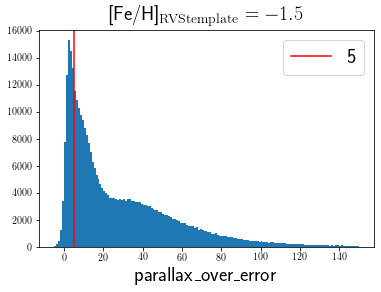

In [7]:

pyplot.hist(data_m1p5['parallax']/data_m1p5['parallax_error'], 
            bins=numpy.linspace(-5,150,156))

pyplot.axvline(x=5, c='red', label=r'5')


pyplot.legend(fontsize=20)

pyplot.xlabel(r'parallax\_over\_error', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=-1.5$', fontsize=20)
pyplot.show()


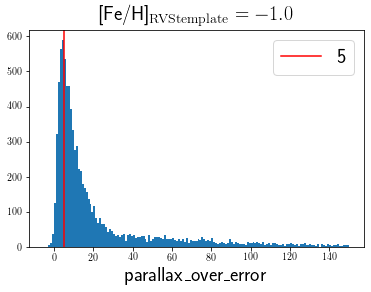

In [8]:

pyplot.hist(data_m1p0['parallax']/data_m1p0['parallax_error'], 
            bins=numpy.linspace(-5,150,156))

pyplot.axvline(x=5, c='red', label=r'5')


pyplot.legend(fontsize=20)

pyplot.xlabel(r'parallax\_over\_error', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=-1.0$', fontsize=20)
pyplot.show()



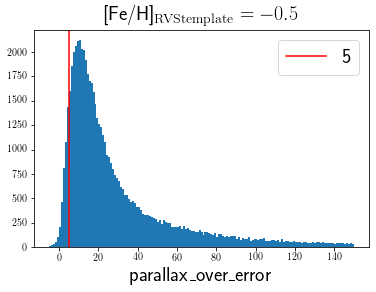

In [9]:

pyplot.hist(data_m0p5['parallax']/data_m0p5['parallax_error'], 
            bins=numpy.linspace(-5,150,156))

pyplot.axvline(x=5, c='red', label=r'5')


pyplot.legend(fontsize=20)

pyplot.xlabel(r'parallax\_over\_error', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=-0.5$', fontsize=20)
pyplot.show()




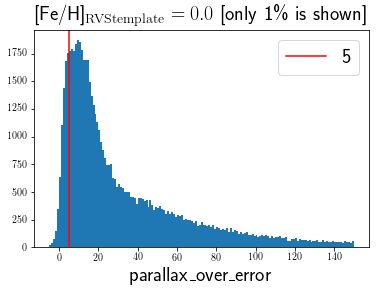

In [10]:

pyplot.hist(data_m0p0['parallax']/data_m0p0['parallax_error'], 
            bins=numpy.linspace(-5,150,156))

pyplot.axvline(x=5, c='red', label=r'5')


pyplot.legend(fontsize=20)

pyplot.xlabel(r'parallax\_over\_error', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=0.0$ [only 1\% is shown]', fontsize=20)
pyplot.show()





## Toomre ediagram

In [11]:
def analyze_data(data):
    source_id             = numpy.array(data['source_id']            [:])
    l                     = numpy.array(data['l']                    [:])
    b                     = numpy.array(data['b']                    [:])
    ra                    = numpy.array(data['ra']                   [:])
    dec                   = numpy.array(data['dec']                  [:])
    parallax              = numpy.array(data['parallax']             [:])
    parallax_error        = numpy.array(data['parallax_error']       [:])
    radial_velocity       = numpy.array(data['radial_velocity']      [:])
    radial_velocity_error = numpy.array(data['radial_velocity_error'][:])
    pmra                  = numpy.array(data['pmra']                 [:])
    pmdec                 = numpy.array(data['pmdec']                [:])
    #pmra_pmdec_corr       = numpy.array(data['pmra_pmdec_corr']      [:])
    
    parallax_over_error = parallax/parallax_error
    
    ell_radian, bee_radian, pml, pmb \
    = ICRS_to_GAL(deg2radian(ra),  
                  deg2radian(dec), 
                  pmra,
                  pmdec)


    xHelio_kpc, yHelio_kpc, zHelio_kpc, vxHelio, vyHelio, vzHelio \
    = astrometric_2_cartesian(parallax_mas_2_DM(parallax),
                              ell_radian,
                              bee_radian,
                              radial_velocity, 
                              pml, 
                              pmb)

    xGC_kpc = xHelio_kpc + _xGC_sun_kpc
    yGC_kpc = yHelio_kpc + _yGC_sun_kpc
    zGC_kpc = zHelio_kpc + _zGC_sun_kpc

    vxGC = vxHelio + _vxGC_sun
    vyGC = vyHelio + _vyGC_sun
    vzGC = vzHelio + _vzGC_sun


    R2GC_kpc = numpy.sqrt(xGC_kpc**2 + yGC_kpc**2)
    rGC_kpc  = numpy.sqrt(xGC_kpc**2 + yGC_kpc**2 + zGC_kpc**2)

    vR   = (xGC_kpc*vxGC + yGC_kpc*vyGC)/R2GC_kpc
    vPHI = (xGC_kpc*vyGC - yGC_kpc*vxGC)/R2GC_kpc

    vr     = (xGC_kpc*vxGC + yGC_kpc*vyGC + zGC_kpc*vzGC)/rGC_kpc
    vTHETA = (-zGC_kpc*xGC_kpc)/(rGC_kpc*R2GC_kpc)*vxGC + (-zGC_kpc*yGC_kpc)/(rGC_kpc*R2GC_kpc)*vyGC + (R2GC_kpc/rGC_kpc)*vzGC

    return vR, vPHI, vzGC, parallax_over_error



In [12]:
vR_m1p5, vPHI_m1p5, vzGC_m1p5, plxOvErr_m1p5 = analyze_data(data_m1p5)

/Users/kohei/rprocess/NearbyGaiaData/halo_fraction/useful_functions.py:618: RuntimeWarning: invalid value encountered in log10
  DM = 5.*( numpy.log10(1./parallax_mas) + 2. )
/Users/kohei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/PyGaia-1.32-py3.6.egg/pygaia/astrometry/vectorastrometry.py:228: RuntimeWarning: invalid value encountered in less_equal


In [13]:
vR_m1p0, vPHI_m1p0, vzGC_m1p0, plxOvErr_m1p0 = analyze_data(data_m1p0)

In [14]:
vR_m0p5, vPHI_m0p5, vzGC_m0p5, plxOvErr_m0p5 = analyze_data(data_m0p5)

In [15]:
vR_m0p0, vPHI_m0p0, vzGC_m0p0, plxOvErr_m0p0 = analyze_data(data_m0p0)

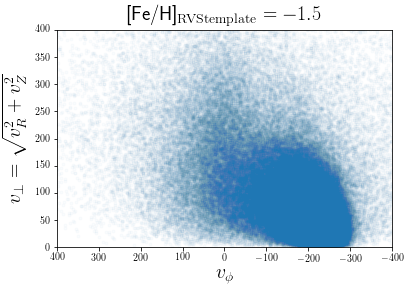

In [16]:
pyplot.plot(vPHI_m1p5, numpy.sqrt(vR_m1p5**2 + vzGC_m1p5**2), 
            '.', linestyle='None', alpha=0.02)
pyplot.xlim([400,-400])
pyplot.ylim([0,400])

pyplot.xlabel(r'$v_\phi$', fontsize=20)
pyplot.ylabel(r'$v_\perp = \sqrt{v_R^2 + v_Z^2}$', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=-1.5$', fontsize=20)
pyplot.show()

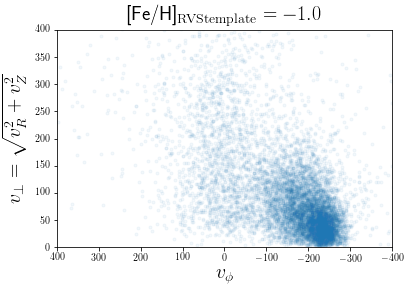

In [17]:
pyplot.plot(vPHI_m1p0, numpy.sqrt(vR_m1p0**2 + vzGC_m1p0**2), 
            '.', linestyle='None', alpha=0.05)
pyplot.xlim([400,-400])
pyplot.ylim([0,400])

pyplot.xlabel(r'$v_\phi$', fontsize=20)
pyplot.ylabel(r'$v_\perp = \sqrt{v_R^2 + v_Z^2}$', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=-1.0$', fontsize=20)


pyplot.show()

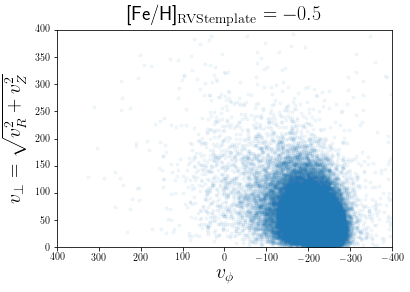

In [18]:
pyplot.plot(vPHI_m0p5, numpy.sqrt(vR_m0p5**2 + vzGC_m0p5**2), 
            '.', linestyle='None', alpha=0.05)
pyplot.xlim([400,-400])
pyplot.ylim([0,400])

pyplot.xlabel(r'$v_\phi$', fontsize=20)
pyplot.ylabel(r'$v_\perp = \sqrt{v_R^2 + v_Z^2}$', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=-0.5$', fontsize=20)



pyplot.show()

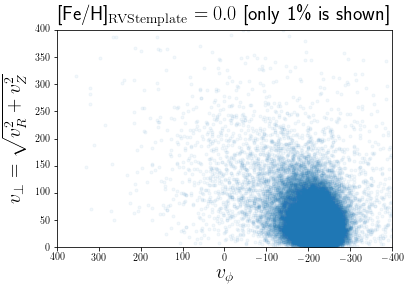

In [19]:
pyplot.plot(vPHI_m0p0, numpy.sqrt(vR_m0p0**2 + vzGC_m0p0**2), 
            '.', linestyle='None', alpha=0.05)
pyplot.xlim([400,-400])
pyplot.ylim([0,400])

pyplot.xlabel(r'$v_\phi$', fontsize=20)
pyplot.ylabel(r'$v_\perp = \sqrt{v_R^2 + v_Z^2}$', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=0.0$ [only 1\% is shown]', fontsize=20)


pyplot.show()

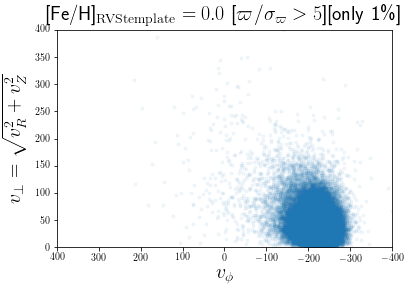

In [20]:
pyplot.plot(vPHI_m0p0[plxOvErr_m0p0>5], 
            numpy.sqrt(vR_m0p0[plxOvErr_m0p0>5]**2 + vzGC_m0p0[plxOvErr_m0p0>5]**2), 
            '.', linestyle='None', alpha=0.05)
pyplot.xlim([400,-400])
pyplot.ylim([0,400])

pyplot.xlabel(r'$v_\phi$', fontsize=20)
pyplot.ylabel(r'$v_\perp = \sqrt{v_R^2 + v_Z^2}$', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=0.0$ [$\varpi/\sigma_\varpi>5$][only 1\%]', fontsize=20)


pyplot.show()

## The fraction of retrograde stars

In [21]:
N_m1p5          = len(vPHI_m1p5)
Nretro_m1p5     = len(vPHI_m1p5[vPHI_m1p5>0])
frac_retro_m1p5 = float(Nretro_m1p5)/N_m1p5

N_m1p0          = len(vPHI_m1p0)
Nretro_m1p0     = len(vPHI_m1p0[vPHI_m1p0>0])
frac_retro_m1p0 = float(Nretro_m1p0)/N_m1p0

N_m0p5          = len(vPHI_m0p5)
Nretro_m0p5     = len(vPHI_m0p5[vPHI_m0p5>0])
frac_retro_m0p5 = float(Nretro_m0p5)/N_m0p5

N_m0p0          = len(vPHI_m0p0)
Nretro_m0p0     = len(vPHI_m0p0[vPHI_m0p0>0])
frac_retro_m0p0 = float(Nretro_m0p0)/N_m0p0


#---
N_m1p5_good          = len(vPHI_m1p5[(plxOvErr_m1p5>5)])
Nretro_m1p5_good     = len(vPHI_m1p5[(plxOvErr_m1p5>5)*(vPHI_m1p5>0)])
frac_retro_m1p5_good = float(Nretro_m1p5_good)/N_m1p5_good

N_m1p0_good          = len(vPHI_m1p0[(plxOvErr_m1p0>5)])
Nretro_m1p0_good     = len(vPHI_m1p0[(plxOvErr_m1p0>5)*(vPHI_m1p0>0)])
frac_retro_m1p0_good = float(Nretro_m1p0_good)/N_m1p0_good

N_m0p5_good          = len(vPHI_m0p5[(plxOvErr_m0p5>5)])
Nretro_m0p5_good     = len(vPHI_m0p5[(plxOvErr_m0p5>5)*(vPHI_m0p5>0)])
frac_retro_m0p5_good = float(Nretro_m0p5_good)/N_m0p5_good

N_m0p0_good          = len(vPHI_m0p0[(plxOvErr_m0p0>5)])
Nretro_m0p0_good     = len(vPHI_m0p0[(plxOvErr_m0p0>5)*(vPHI_m0p0>0)])
frac_retro_m0p0_good = float(Nretro_m0p0_good)/N_m0p0_good

#---

array_FeH = numpy.array([-1.5, -1., -0.5, 0])

array_frac_retro= numpy.array([frac_retro_m1p5, 
                               frac_retro_m1p0, 
                               frac_retro_m0p5,
                               frac_retro_m0p0 ])
array_N_retro   = numpy.array([Nretro_m1p5, 
                               Nretro_m1p0, 
                               Nretro_m0p5,
                               Nretro_m0p0*1e2 ])


array_frac_retro_good= numpy.array([frac_retro_m1p5_good, 
                                    frac_retro_m1p0_good, 
                                    frac_retro_m0p5_good,
                                    frac_retro_m0p0_good ])
array_N_retro_good=numpy.array([Nretro_m1p5_good, 
                                Nretro_m1p0_good, 
                                Nretro_m0p5_good,
                                Nretro_m0p0_good*1e2 ])


print('# [Fe/H], N(total), N(retrograde), N(retrograde)/N(total)')
print('#','-'*60)
print(-1.5, Nretro_m1p5, N_m1p5, '%.4lf' % (float(Nretro_m1p5)/N_m1p5))
print(-1.0, Nretro_m1p0, N_m1p0, '%.4lf' % (float(Nretro_m1p0)/N_m1p0))
print(-0.5, Nretro_m0p5, N_m0p5, '%.4lf' % (frac_retro_m0p5))
print( 0.0, Nretro_m0p0, N_m0p0, '%.4lf' % (frac_retro_m0p0), '# Only 1 percent of stars are used')

print('#','-'*60)

print(-1.5, Nretro_m1p5_good, N_m1p5_good, '%.4lf' % (frac_retro_m1p5_good))
print(-1.0, Nretro_m1p0_good, N_m1p0_good, '%.4lf' % (frac_retro_m1p0_good))
print(-0.5, Nretro_m0p5_good, N_m0p5_good, '%.4lf' % (frac_retro_m0p5_good))
print( 0.0, Nretro_m0p0_good, N_m0p0_good, '%.4lf' % (frac_retro_m0p0_good), '# Only 1 percent of stars are used')



# [Fe/H], N(total), N(retrograde), N(retrograde)/N(total)
# ------------------------------------------------------------
-1.5 24633 366241 0.0673
-1.0 1144 9364 0.1222
-0.5 405 63408 0.0064
0.0 408 65368 0.0062 # Only 1 percent of stars are used
# ------------------------------------------------------------
-1.5 10667 296783 0.0359
-1.0 605 7230 0.0837
-0.5 210 59180 0.0035
0.0 95 58064 0.0016 # Only 1 percent of stars are used


/Users/kohei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/Users/kohei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/kohei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/Users/kohei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/kohei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/Users/kohei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/Users/kohei/.pyenv/version

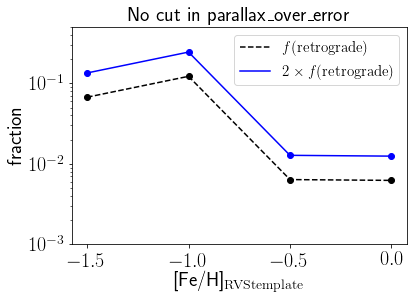

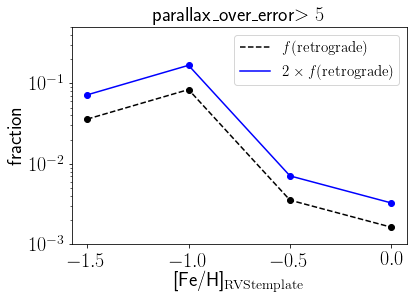

In [22]:
pyplot.plot(array_FeH, 
            array_frac_retro,  
            'k--', label=r'$f(\mathrm{retrograde})$')
pyplot.plot(array_FeH, 
            array_frac_retro,
            'ko')

pyplot.plot(array_FeH, 
            array_frac_retro*2.,  
            'b-', label=r'$2\times f(\mathrm{retrograde})$')
pyplot.plot(array_FeH, 
            array_frac_retro*2.,  
            'bo')

pyplot.xticks(numpy.linspace(-1.5,0.,4),fontsize=20)
pyplot.yticks(numpy.linspace(0.0,0.25,6),fontsize=20)
pyplot.ylim([0.001,0.5])
pyplot.yscale('log')
pyplot.xlabel(r'[Fe/H]$_\mathrm{RVStemplate}$', fontsize=20)
pyplot.ylabel(r'fraction', fontsize=20)
pyplot.title(r'No cut in parallax\_over\_error', fontsize=20)
pyplot.legend(loc='upper right', fontsize=15)
pyplot.show()

pyplot.plot(array_FeH, 
            array_frac_retro_good,  
            'k--', label=r'$f(\mathrm{retrograde})$')
pyplot.plot(array_FeH, 
            array_frac_retro_good,
            'ko')

pyplot.plot(array_FeH, 
            array_frac_retro_good*2.,  
            'b-', label=r'$2\times f(\mathrm{retrograde})$')
pyplot.plot(array_FeH, 
            array_frac_retro_good*2.,  
            'bo')

pyplot.xticks(numpy.linspace(-1.5,0.,4),fontsize=20)
pyplot.yticks(numpy.linspace(0.0,0.25,6),fontsize=20)
pyplot.ylim([0.001,0.5])
pyplot.yscale('log')
pyplot.xlabel(r'[Fe/H]$_\mathrm{RVStemplate}$', fontsize=20)
pyplot.ylabel(r'fraction', fontsize=20)
pyplot.title(r'parallax\_over\_error$>5$', fontsize=20)
pyplot.legend(loc='upper right', fontsize=15)
pyplot.show()





## The number of retrograde stars

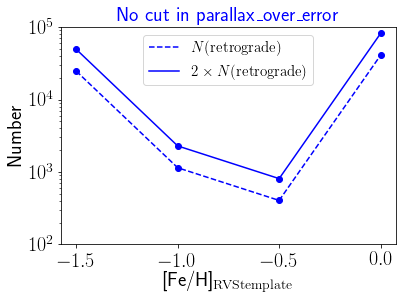

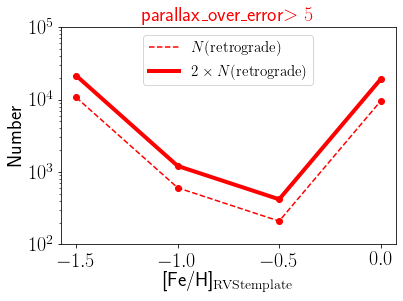

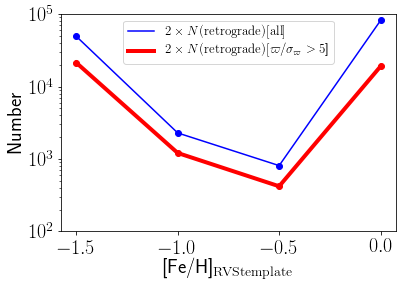

In [29]:
pyplot.plot(array_FeH, 
            array_N_retro,  
            'b--', label=r'$N(\mathrm{retrograde})$')
pyplot.plot(array_FeH, 
            array_N_retro,
            'bo')

pyplot.plot(array_FeH, 
            array_N_retro*2.,  
            'b-', label=r'$2\times N(\mathrm{retrograde})$')
pyplot.plot(array_FeH, 
            array_N_retro*2.,  
            'bo')

pyplot.xticks(numpy.linspace(-1.5,0.,4),fontsize=20)
pyplot.yticks(numpy.linspace(0.0,0.25,6),fontsize=20)
pyplot.ylim([1e2,1e5])
pyplot.yscale('log')
pyplot.xlabel(r'[Fe/H]$_\mathrm{RVStemplate}$', fontsize=20)
pyplot.ylabel(r'Number', fontsize=20)

pyplot.legend(loc='upper center', fontsize=15)
pyplot.title(r'No cut in parallax\_over\_error', fontsize=20, color='b')


pyplot.show()


# ----- 

pyplot.plot(array_FeH, 
            array_N_retro_good,  
            'r--', label=r'$N(\mathrm{retrograde})$')
pyplot.plot(array_FeH, 
            array_N_retro_good,
            'ro')

pyplot.plot(array_FeH, 
            array_N_retro_good*2.,  
            'r-', linewidth=4,
            label=r'$2\times N(\mathrm{retrograde})$')
pyplot.plot(array_FeH, 
            array_N_retro_good*2.,  
            'ro')

pyplot.xticks(numpy.linspace(-1.5,0.,4),fontsize=20)
pyplot.yticks(numpy.linspace(0.0,0.25,6),fontsize=20)
pyplot.ylim([1e2,1e5])
pyplot.yscale('log')
pyplot.xlabel(r'[Fe/H]$_\mathrm{RVStemplate}$', fontsize=20)
pyplot.ylabel(r'Number', fontsize=20)

pyplot.legend(loc='upper center', fontsize=15)
pyplot.title(r'parallax\_over\_error$>5$', fontsize=20, color='r')

pyplot.show()


# ----- 

pyplot.plot(array_FeH, 
            array_N_retro*2.,  
            'b-', label=r'$2\times N(\mathrm{retrograde}) [\mathrm{all}]$')
pyplot.plot(array_FeH, 
            array_N_retro*2.,  
            'bo')

pyplot.plot(array_FeH, 
            array_N_retro_good*2.,  
            'r-', linewidth=4, 
            label=r'$2\times N(\mathrm{retrograde}) [\varpi/\sigma_\varpi>5$]')
pyplot.plot(array_FeH, 
            array_N_retro_good*2.,  
            'ro')

pyplot.xticks(numpy.linspace(-1.5,0.,4),fontsize=20)
pyplot.yticks(numpy.linspace(0.0,0.25,6),fontsize=20)
pyplot.ylim([1e2,1e5])
pyplot.yscale('log')
pyplot.xlabel(r'[Fe/H]$_\mathrm{RVStemplate}$', fontsize=20)
pyplot.ylabel(r'Number', fontsize=20)

pyplot.legend(loc='upper center', fontsize=13)
#pyplot.title(r'parallax\_over\_error$>5$', fontsize=20, color='r')

pyplot.show()

